In [1]:
%matplotlib inline
import math
import pandas as pd
from tsmom_model import *
import numpy as np
import statsmodels.tsa.vector_ar.var_model as VAR
from datetime import datetime
token="Us3wFmXGgAj_1cUtHAAR"

import pylab
sns.set(font_scale=3)
pylab.rcParams['figure.figsize'] = (24, 18)

:0: FutureWarning: IPython widgets are experimental and may change in the future.


# Correlation approach to clense data
Use pairwise correlation in order to decide which which markets are duplicates then use the one with the longer history. 

In [2]:
cleansed=load_amihud_markets_price()

tsmom_model.py:146: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  data=pd.read_csv('Price.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='last')
tsmom_model.py:148: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  qd=pd.read_csv('liquid_contracts.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='last')


In [3]:
cleansed.count().count()

123

# Amihud methodology

Amihud (2002) developed the illiquidity measure expressed by:

$$ Amihud = \frac{|r_t|}{\text{volume}_t} $$

where $r_t$ is the return on day $t$ and $Volume_t$ is the dollar volume on day $t$. 

The benefit of taking the daily return is to weight the move by change of price and the volume.


In [4]:
amihud=calculate_amihud_liquidity(cleansed)[:'2016'] 

tsmom_model.py:29: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  data=pd.read_csv('Volume.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='mean')
tsmom_model.py:31: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  v=pd.read_csv('volume_data.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='sum')
tsmom_model.py:33: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(min_periods=100,window=250,center=False).mean()
  volume=pd.rolling_mean(v,250,min_periods=100).resample(rule='d',how='mean')[:'2016']
tsmom_model.py:33: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  volume=pd.rolling_mean(v,250,min_periods=100).resample(rule='d',how='mean')[:'2016']
tsmom_model.py:36: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future versio

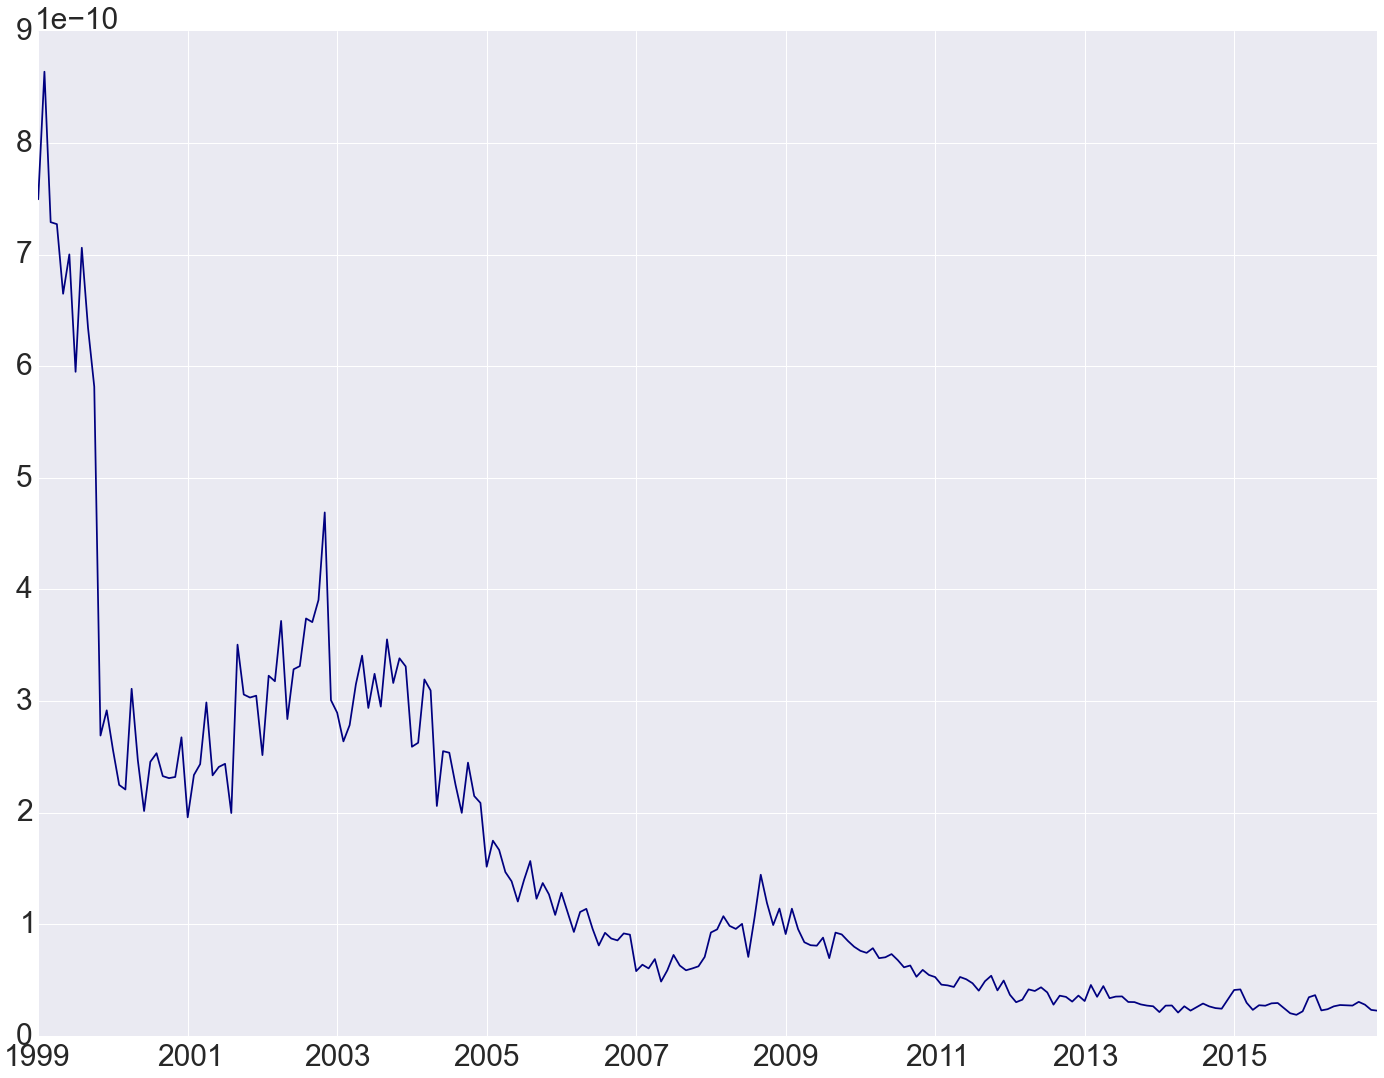

In [5]:
amihud.median(axis=1).dropna().plot(colormap='jet')

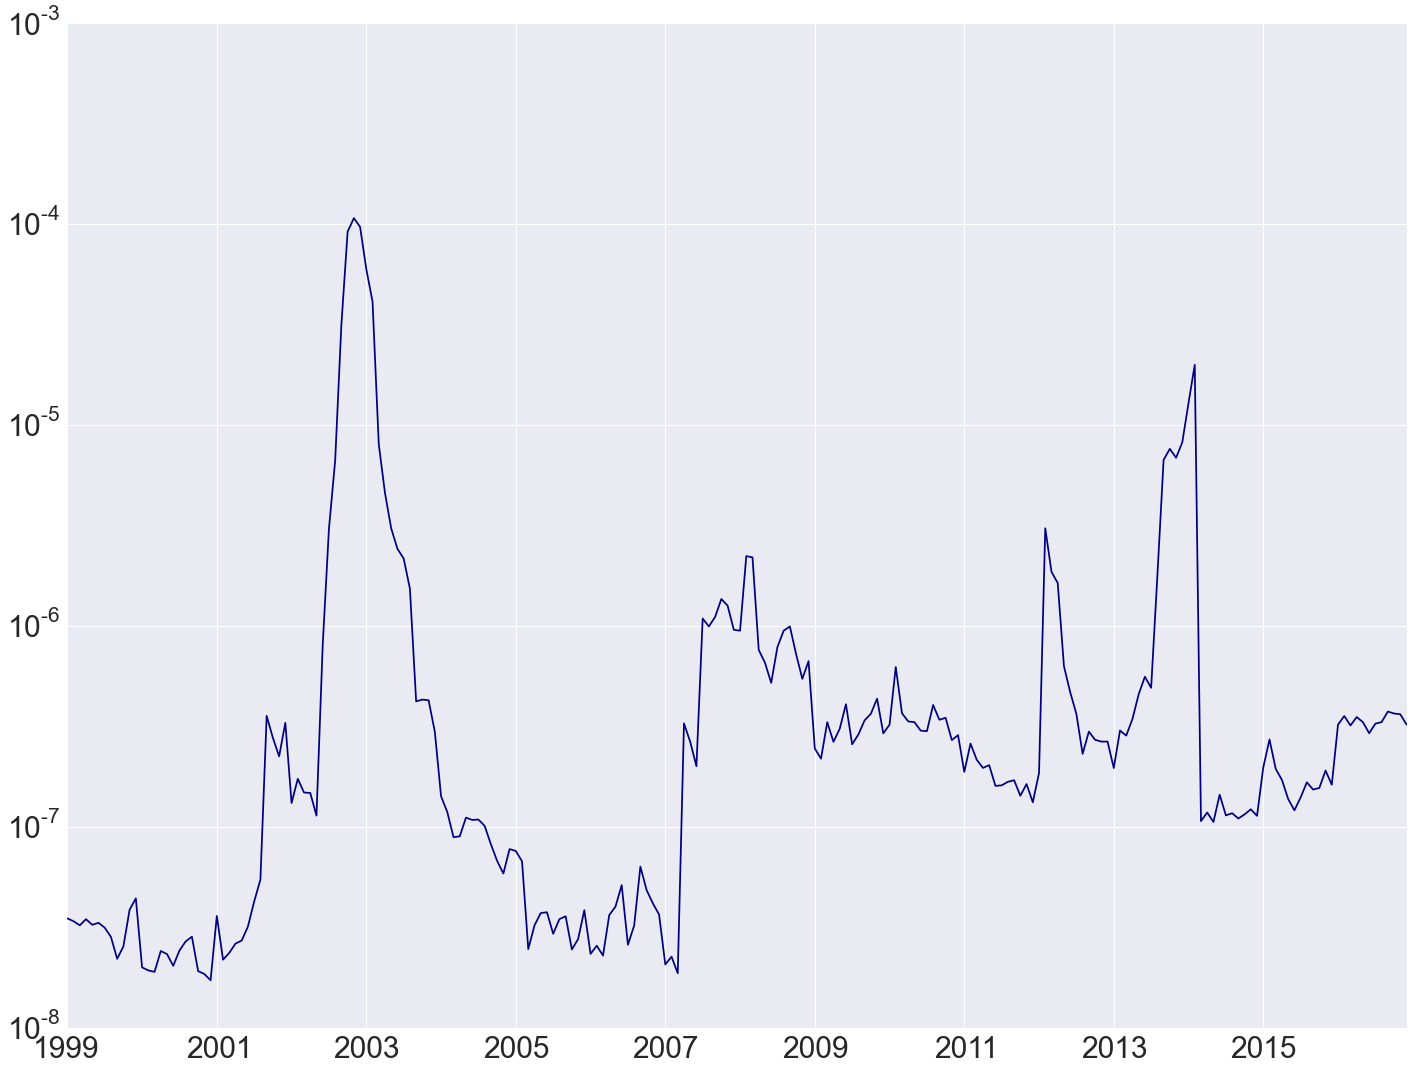

In [6]:
amihud.std(axis=1).dropna().plot(logy=True,colormap='jet')

In [10]:
df=pd.DataFrame()
df['LIBOR']=quandl.get('FRED/USDONTD156N').VALUE.resample(rule='m',how='last')
df['FedFunds']=quandl.get('FRED/FEDFUNDS').Value.resample(rule='m',how='last')
df['TED']=quandl.get('FRED/TEDRATE').Value.resample(rule='m',how='last')
df['FinancialStress']=quandl.get('FRED/STLFSI').Value.resample(rule='m',how='last')
df['NBER_Recessions']=quandl.get('FRED/USREC').Value.resample(rule='m',how='last')


/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  from IPython.kernel.zmq import kernelapp as app
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  app.launch_new_instance()
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:4: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:5: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()


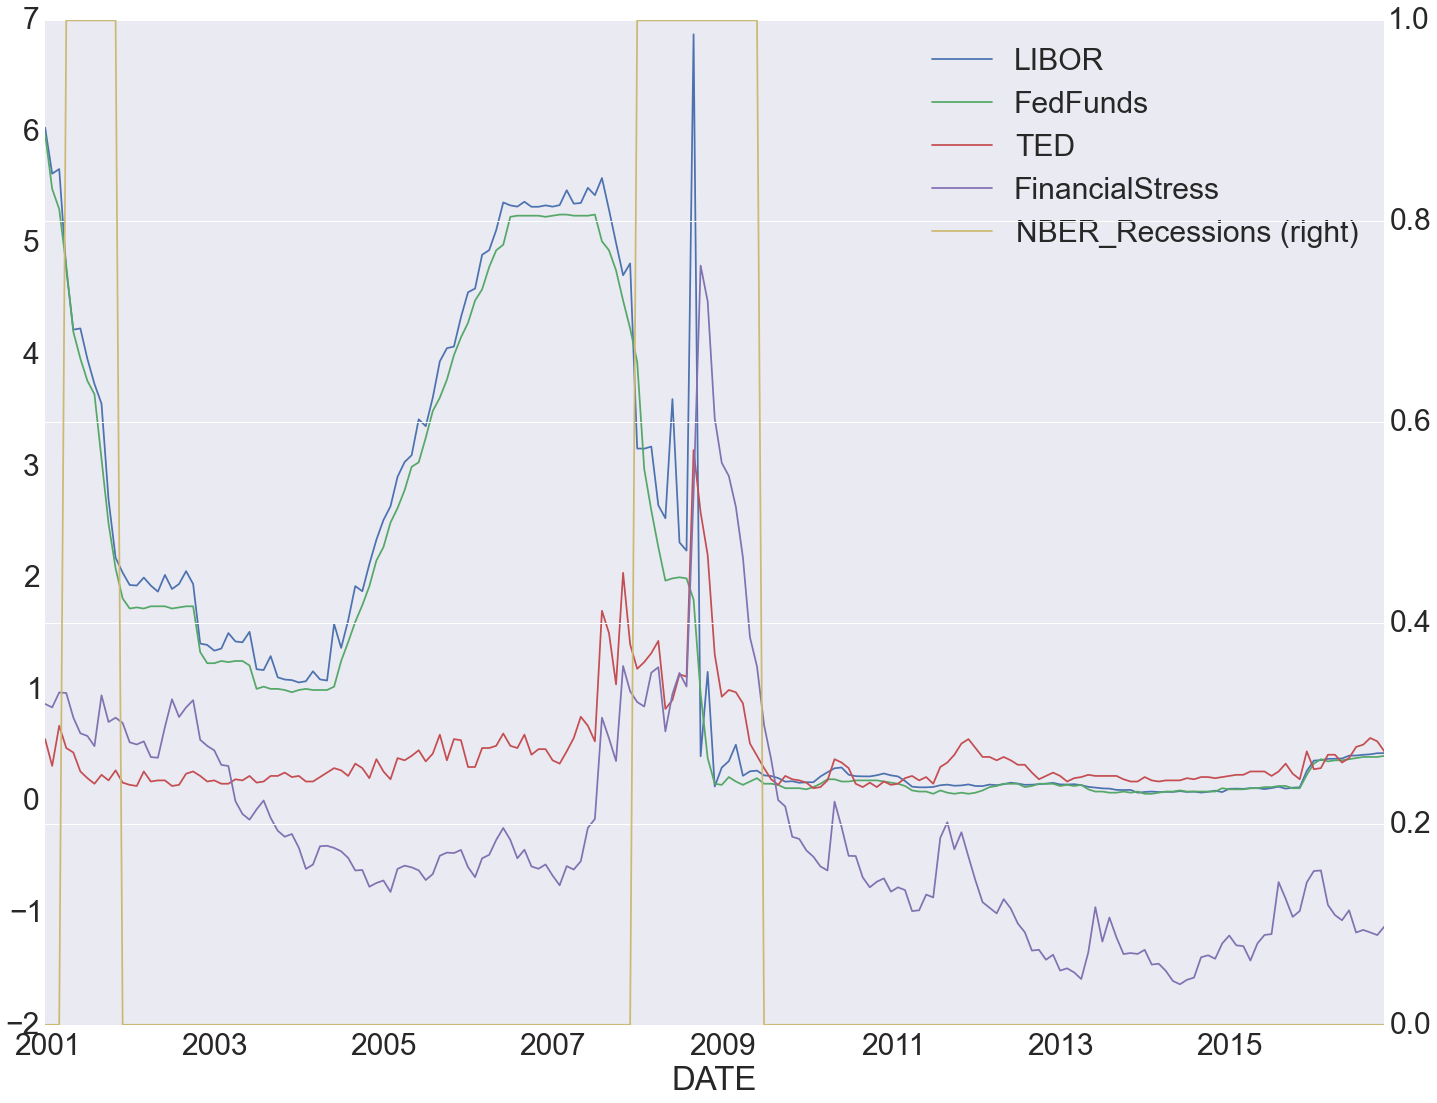

In [12]:
df.plot(secondary_y='NBER_Recessions')

* Run regression on time series of Amihud 
* Break into recession and post recession periods
* Get Currency variance model to copy their approach
* Get VIX as well
